Aggregating tweets keywords relations (NLI keyword scores) by stock and day

# Importing data

In [18]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_df_from_json_tweets_data(path_tweets,
                                    relevant_fields = ['author','text','createdAt'],
                                    relevant_author_fields = ['userName','description']):
    dict_list = []

    # For each JSON
    for filename in os.listdir(path_tweets):
        if filename[-4:] != 'json':
            continue

        with open(os.path.join(path_tweets, filename), 'rt', encoding= 'utf8') as f:
            curr_json_list = json.load(f)

        # For each single tweet in a JSON
        for curr_json in curr_json_list:
            # Extract only relevant fields from tweet
            relevant_json = {k:v for k,v in curr_json.items() if k in relevant_fields}
            
            relevant_json_author = {f'author_{k}':v for k,v in relevant_json['author'].items() if k in relevant_author_fields}

            # Delete semi-structured author field in `relevant_json`
            del relevant_json['author']

            # Merging the two dataframes and specifying original file
            new_dict = {**relevant_json, **relevant_json_author}
            new_dict['src_file'] = filename
            dict_list.append(new_dict)

    df = pd.DataFrame(dict_list)
    return df

In [3]:
RELEVANT_FIELDS = ['type','id','text','retweetCount','replyCount','likeCount','createdAt','bookmarkCount','isReply','author']
RELEVANT_AUTHOR_FIELDS = ['type','userName','name','isVerified','description','followers','following','createdAt','favouritesCount']
PATH_PETR4 = os.path.join('data','PETR4')
PATH_VALE3 = os.path.join('data','VALE3')


df_petr4 = extract_df_from_json_tweets_data(PATH_PETR4, relevant_fields=RELEVANT_FIELDS, relevant_author_fields=RELEVANT_AUTHOR_FIELDS)
df_vale3 = extract_df_from_json_tweets_data(PATH_VALE3, relevant_fields=RELEVANT_FIELDS, relevant_author_fields=RELEVANT_AUTHOR_FIELDS)

df_petr4['stock'] = 'PETR4'
df_vale3['stock'] = 'VALE3'

df_stocks = pd.concat([df_petr4, df_vale3], ignore_index=True)
df_stocks.head()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/PETR4'

In [ ]:
PATH_NLI_FEATURES = 'data/additonal_features/tweets_keywords_relations.csv'

df_tweets_keywords_relations = pd.read_csv(PATH_NLI_FEATURES)
df_tweets_keywords_relations.shape, df_stocks.shape

((4800, 9), (4800, 20))

# Merging tweets and NLI features dataframes

In [ ]:
df_merged = pd.merge(df_stocks, df_tweets_keywords_relations, on='text', how='inner')
df_merged.shape

(5114, 28)

In [ ]:
df_stocks = df_merged.drop_duplicates().reset_index(drop=True)
df_stocks.shape

(4800, 28)

# Preprocessing 

In [ ]:
df_stocks['createdAt'] = pd.to_datetime(df_stocks['createdAt'], format='%a %b %d %H:%M:%S %z %Y')
df_stocks['author_createdAt'] = pd.to_datetime(df_stocks['author_createdAt'], format='%a %b %d %H:%M:%S %z %Y')
df_stocks['isReply'] = df_stocks['isReply'].map({False:0, True:1})
df_stocks['author_isVerified'] = df_stocks['author_isVerified'].map({False:0, True:1})

df_stocks.dtypes

type                                   object
id                                     object
text                                   object
retweetCount                            int64
replyCount                              int64
likeCount                               int64
createdAt                 datetime64[ns, UTC]
bookmarkCount                           int64
isReply                                 int64
author_type                            object
author_userName                        object
author_name                            object
author_isVerified                       int64
author_description                     object
author_followers                        int64
author_following                        int64
author_createdAt          datetime64[ns, UTC]
author_favouritesCount                  int64
src_file                               object
stock                                  object
valorização                           float64
bom negócio                       

In [ ]:
df_stocks['date'] = df_stocks['createdAt'].dt.strftime('%Y-%m-%d')

# Aggregating NLI scores by stock and day

In [ ]:
nli_scores_columns = ['valorização', 'bom negócio', 'lucro', 'neutro', 'desvalorização','mau negócio', 'prejuízo', 'governo']

def q1(d): return np.quantile(d, 0.25)
def q3(d): return np.quantile(d, 0.75)
def count(d): return len(d)


df_agg_scores = df_stocks.groupby(['stock', 'date'])[nli_scores_columns]\
    .agg(['mean', 'median', q1, q3, count])\
    .reset_index()
df_agg_scores.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df_agg_scores.columns]
df_agg_scores

,stock,date,valorização_mean,valorização_median,valorização_q1,valorização_q3,valorização_count,bom negócio_mean,bom negócio_median,bom negócio_q1,...,prejuízo_mean,prejuízo_median,prejuízo_q1,prejuízo_q3,prejuízo_count,governo_mean,governo_median,governo_q1,governo_q3,governo_count
0,PETR4,2022-06-20,0.501828,0.501828,0.253213,0.750443,2,0.491784,0.491784,0.367215,...,0.099494,0.099494,0.077469,0.121519,2,0.887368,0.887368,0.886389,0.888347,2
1,PETR4,2022-06-21,0.492677,0.702372,0.352771,0.737430,3,0.637464,0.917190,0.459290,...,0.658344,0.974249,0.488684,0.985957,3,0.969860,0.969837,0.956078,0.983632,3
2,PETR4,2022-06-22,0.515149,0.513790,0.241698,0.787241,4,0.584791,0.506800,0.443946,...,0.153312,0.055814,0.007772,0.201354,4,0.316087,0.322490,0.238390,0.400187,4
3,PETR4,2022-06-23,0.501441,0.569799,0.317980,0.719081,3,0.173901,0.159400,0.081165,...,0.953681,0.951754,0.943652,0.962747,3,0.343535,0.362926,0.307173,0.389594,3
4,PETR4,2022-06-24,0.412842,0.479427,0.044501,0.640905,5,0.289468,0.131425,0.097198,...,0.381512,0.405415,0.377095,0.443212,5,0.620378,0.765793,0.337609,0.948904,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,VALE3,2024-05-27,0.588541,0.748972,0.411575,0.812859,5,0.553513,0.663868,0.639569,...,0.164783,0.015382,0.013599,0.039807,5,0.456577,0.528233,0.402417,0.644755,5
852,VALE3,2024-05-28,0.702186,0.724803,0.562714,0.864276,4,0.737152,0.702927,0.636298,...,0.434027,0.435718,0.028030,0.841715,4,0.280694,0.079572,0.017608,0.342658,4
853,VALE3,2024-05-29,0.532552,0.532929,0.071492,0.993988,4,0.641740,0.769118,0.572464,...,0.555062,0.615430,0.252097,0.918396,4,0.681841,0.755330,0.474074,0.963098,4
854,VALE3,2024-05-30,0.999218,0.999218,0.999218,0.999218,1,0.884908,0.884908,0.884908,...,0.278165,0.278165,0.278165,0.278165,1,0.560456,0.560456,0.560456,0.560456,1


In [ ]:
date_range = pd.date_range(start='2022-06-01', end='2024-05-31', freq='D')

df_petr4_dates = pd.DataFrame(date_range.strftime('%Y-%m-%d'), columns=['date'])
df_petr4_dates['stock'] = 'PETR4'
df_vale3_dates = pd.DataFrame(date_range.strftime('%Y-%m-%d'), columns=['date'])
df_vale3_dates['stock'] = 'VALE3'

df_stock_dates = pd.concat([df_petr4_dates, df_vale3_dates], ignore_index=True)
df_stock_dates

,date,stock
0,2022-06-01,PETR4
1,2022-06-02,PETR4
2,2022-06-03,PETR4
3,2022-06-04,PETR4
4,2022-06-05,PETR4
...,...,...
1457,2024-05-27,VALE3
1458,2024-05-28,VALE3
1459,2024-05-29,VALE3
1460,2024-05-30,VALE3


## Merging dataframes

In [ ]:
df_agg_scores_by_day = pd.merge(df_stock_dates, df_agg_scores, how='left', on=['stock', 'date'])

In [ ]:
# Flagging days that have no tweets
df_agg_scores_by_day.loc[df_agg_scores_by_day.isna().any(axis=1), 'has_tweets'] = 0
df_agg_scores_by_day['has_tweets'] = df_agg_scores_by_day['has_tweets'].fillna(value=1)
df_agg_scores_by_day


,date,stock,valorização_mean,valorização_median,valorização_q1,valorização_q3,valorização_count,bom negócio_mean,bom negócio_median,bom negócio_q1,...,prejuízo_median,prejuízo_q1,prejuízo_q3,prejuízo_count,governo_mean,governo_median,governo_q1,governo_q3,governo_count,has_tweets
0,2022-06-01,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2022-06-02,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2022-06-03,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2022-06-04,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2022-06-05,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2024-05-27,VALE3,0.588541,0.748972,0.411575,0.812859,5.0,0.553513,0.663868,0.639569,...,0.015382,0.013599,0.039807,5.0,0.456577,0.528233,0.402417,0.644755,5.0,1.0
1458,2024-05-28,VALE3,0.702186,0.724803,0.562714,0.864276,4.0,0.737152,0.702927,0.636298,...,0.435718,0.028030,0.841715,4.0,0.280694,0.079572,0.017608,0.342658,4.0,1.0
1459,2024-05-29,VALE3,0.532552,0.532929,0.071492,0.993988,4.0,0.641740,0.769118,0.572464,...,0.615430,0.252097,0.918396,4.0,0.681841,0.755330,0.474074,0.963098,4.0,1.0
1460,2024-05-30,VALE3,0.999218,0.999218,0.999218,0.999218,1.0,0.884908,0.884908,0.884908,...,0.278165,0.278165,0.278165,1.0,0.560456,0.560456,0.560456,0.560456,1.0,1.0


In [ ]:
# Obtaining datetime column and splitting dataframe by each stock
df_agg_scores_by_day['datetime'] = pd.to_datetime(df_agg_scores_by_day['date'])
df_agg_scores_by_day_petr4 = df_agg_scores_by_day.query('stock == "PETR4"')
df_agg_scores_by_day_vale3 = df_agg_scores_by_day.query('stock == "VALE3"')

In [ ]:
# Checking that dataframes are CRONOLOGICALLY ORDERED
df_agg_scores_by_day_vale3['datetime'].is_monotonic_increasing,\
df_agg_scores_by_day_petr4['datetime'].is_monotonic_increasing

(True, True)

In [ ]:
# Using the fillna method with the argument "method='bfill'"
# To fill NaN values with the LAST valid instance found
df_agg_scores_by_day_petr4 = df_agg_scores_by_day_petr4.fillna(method='ffill')
df_agg_scores_by_day_vale3 = df_agg_scores_by_day_vale3.fillna(method='ffill')

In [ ]:
df_agg_scores_by_day_petr4[:21]

,date,stock,valorização_mean,valorização_median,valorização_q1,valorização_q3,valorização_count,bom negócio_mean,bom negócio_median,bom negócio_q1,...,prejuízo_q1,prejuízo_q3,prejuízo_count,governo_mean,governo_median,governo_q1,governo_q3,governo_count,has_tweets,datetime
0,2022-06-01,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-01
1,2022-06-02,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-02
2,2022-06-03,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-03
3,2022-06-04,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-04
4,2022-06-05,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-05
5,2022-06-06,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-06
6,2022-06-07,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-07
7,2022-06-08,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-08
8,2022-06-09,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-09
9,2022-06-10,PETR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-06-10


### Treating initial NaNs from PETR4

In [ ]:
# Replacing NaNs by first values in the dataframe
df_agg_scores_by_day_petr4 = df_agg_scores_by_day_petr4.fillna(method='bfill')
df_agg_scores_by_day_petr4[:21]

,date,stock,valorização_mean,valorização_median,valorização_q1,valorização_q3,valorização_count,bom negócio_mean,bom negócio_median,bom negócio_q1,...,prejuízo_q1,prejuízo_q3,prejuízo_count,governo_mean,governo_median,governo_q1,governo_q3,governo_count,has_tweets,datetime
0,2022-06-01,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-01
1,2022-06-02,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-02
2,2022-06-03,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-03
3,2022-06-04,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-04
4,2022-06-05,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-05
5,2022-06-06,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-06
6,2022-06-07,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-07
7,2022-06-08,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-08
8,2022-06-09,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-09
9,2022-06-10,PETR4,0.501828,0.501828,0.253213,0.750443,2.0,0.491784,0.491784,0.367215,...,0.077469,0.121519,2.0,0.887368,0.887368,0.886389,0.888347,2.0,0.0,2022-06-10


In [ ]:
df_agg_scores_by_day = pd.concat([df_agg_scores_by_day_petr4, df_agg_scores_by_day_vale3], ignore_index=True)

In [ ]:
# Adjusting col types
for col in df_agg_scores_by_day.columns:
    if 'count' in col:
        df_agg_scores_by_day[col] = df_agg_scores_by_day[col].astype(int)

df_agg_scores_by_day['has_tweets'] = df_agg_scores_by_day['has_tweets'].astype(int)
df_agg_scores_by_day = df_agg_scores_by_day.drop(['date'], axis='columns')


In [ ]:
df_agg_scores_by_day

,stock,valorização_mean,valorização_median,valorização_q1,valorização_q3,valorização_count,bom negócio_mean,bom negócio_median,bom negócio_q1,bom negócio_q3,...,prejuízo_q1,prejuízo_q3,prejuízo_count,governo_mean,governo_median,governo_q1,governo_q3,governo_count,has_tweets,datetime
0,PETR4,0.501828,0.501828,0.253213,0.750443,2,0.491784,0.491784,0.367215,0.616352,...,0.077469,0.121519,2,0.887368,0.887368,0.886389,0.888347,2,0,2022-06-01
1,PETR4,0.501828,0.501828,0.253213,0.750443,2,0.491784,0.491784,0.367215,0.616352,...,0.077469,0.121519,2,0.887368,0.887368,0.886389,0.888347,2,0,2022-06-02
2,PETR4,0.501828,0.501828,0.253213,0.750443,2,0.491784,0.491784,0.367215,0.616352,...,0.077469,0.121519,2,0.887368,0.887368,0.886389,0.888347,2,0,2022-06-03
3,PETR4,0.501828,0.501828,0.253213,0.750443,2,0.491784,0.491784,0.367215,0.616352,...,0.077469,0.121519,2,0.887368,0.887368,0.886389,0.888347,2,0,2022-06-04
4,PETR4,0.501828,0.501828,0.253213,0.750443,2,0.491784,0.491784,0.367215,0.616352,...,0.077469,0.121519,2,0.887368,0.887368,0.886389,0.888347,2,0,2022-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,VALE3,0.588541,0.748972,0.411575,0.812859,5,0.553513,0.663868,0.639569,0.689314,...,0.013599,0.039807,5,0.456577,0.528233,0.402417,0.644755,5,1,2024-05-27
1458,VALE3,0.702186,0.724803,0.562714,0.864276,4,0.737152,0.702927,0.636298,0.803780,...,0.028030,0.841715,4,0.280694,0.079572,0.017608,0.342658,4,1,2024-05-28
1459,VALE3,0.532552,0.532929,0.071492,0.993988,4,0.641740,0.769118,0.572464,0.838395,...,0.252097,0.918396,4,0.681841,0.755330,0.474074,0.963098,4,1,2024-05-29
1460,VALE3,0.999218,0.999218,0.999218,0.999218,1,0.884908,0.884908,0.884908,0.884908,...,0.278165,0.278165,1,0.560456,0.560456,0.560456,0.560456,1,1,2024-05-30


In [ ]:
# df_agg_scores_by_day.to_csv('tweets_keywords_relations_agg_by_day.csv', index=False)

In [24]:
extra = ['Date',
 'valorização_median',
 'valorização_q1',
 'valorização_q3',
 'valorização_count',
 'bom negócio_median',
 'bom negócio_q1',
 'bom negócio_q3',
 'bom negócio_count',
 'lucro_median',
 'lucro_q1',
 'lucro_q3',
 'lucro_count',
 'neutro_median',
 'neutro_q1',
 'neutro_q3',
 'neutro_count',
 'desvalorização_median',
 'desvalorização_q1',
 'desvalorização_q3',
 'desvalorização_count',
 'mau negócio_median',
 'mau negócio_q1',
 'mau negócio_q3',
 'mau negócio_count',
 'prejuízo_median',
 'prejuízo_q1',
 'prejuízo_q3',
 'prejuízo_count',
 'governo_median',
 'governo_q1',
 'governo_q3',
 'governo_count',
 'stock'
]

acoes = {}

for acao in ["PETR4", "VALE3"]:
    acoes[acao] = pd.read_csv(os.path.join("TimeSeries",f"{acao}_prices_and_tweets_NLI_scores.csv")).drop(columns=extra)
    


In [34]:
df["Close"].iloc[:-1]

0      1.023785
1      1.043044
2      1.026337
3      1.027381
4      1.051398
         ...   
493    0.754728
494    0.755076
495    0.757629
496    0.741269
497    0.733728
Name: Close, Length: 498, dtype: float64

In [37]:
np.array([1,2]).tolist()

[1, 2]

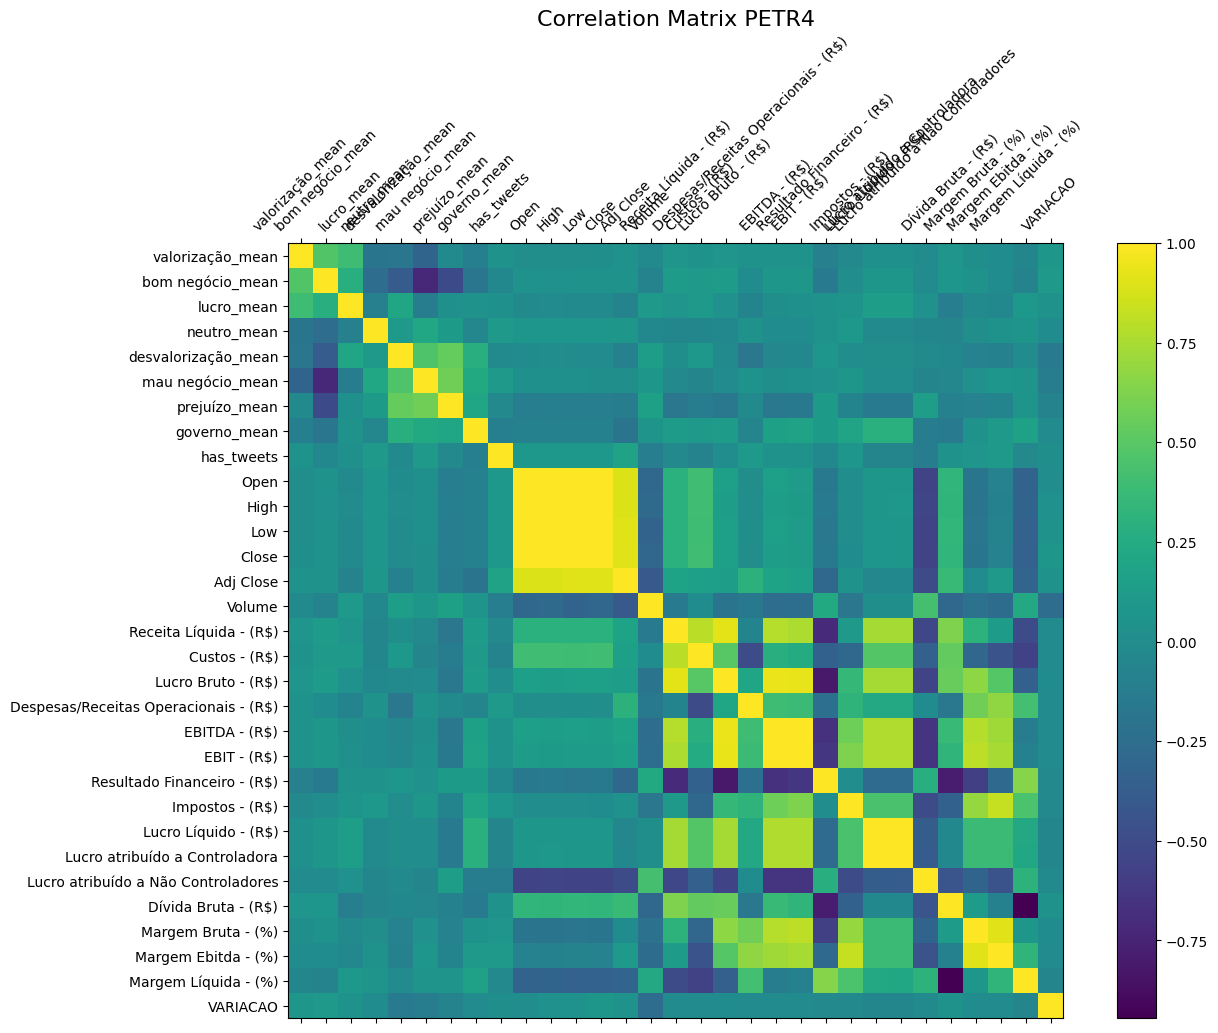

valorização_mean                         0.082229
bom negócio_mean                         0.107009
lucro_mean                               0.053306
neutro_mean                              0.004279
desvalorização_mean                     -0.134127
mau negócio_mean                        -0.120497
prejuízo_mean                           -0.073485
governo_mean                            -0.003082
has_tweets                               0.023058
Open                                     0.008596
High                                     0.037097
Low                                      0.055717
Close                                    0.081628
Adj Close                                0.046433
Volume                                  -0.252162
Receita Líquida - (R$)                  -0.004470
Custos - (R$)                           -0.005024
Lucro Bruto - (R$)                      -0.002635
Despesas/Receitas Operacionais - (R$)   -0.006344
EBITDA - (R$)                           -0.007912


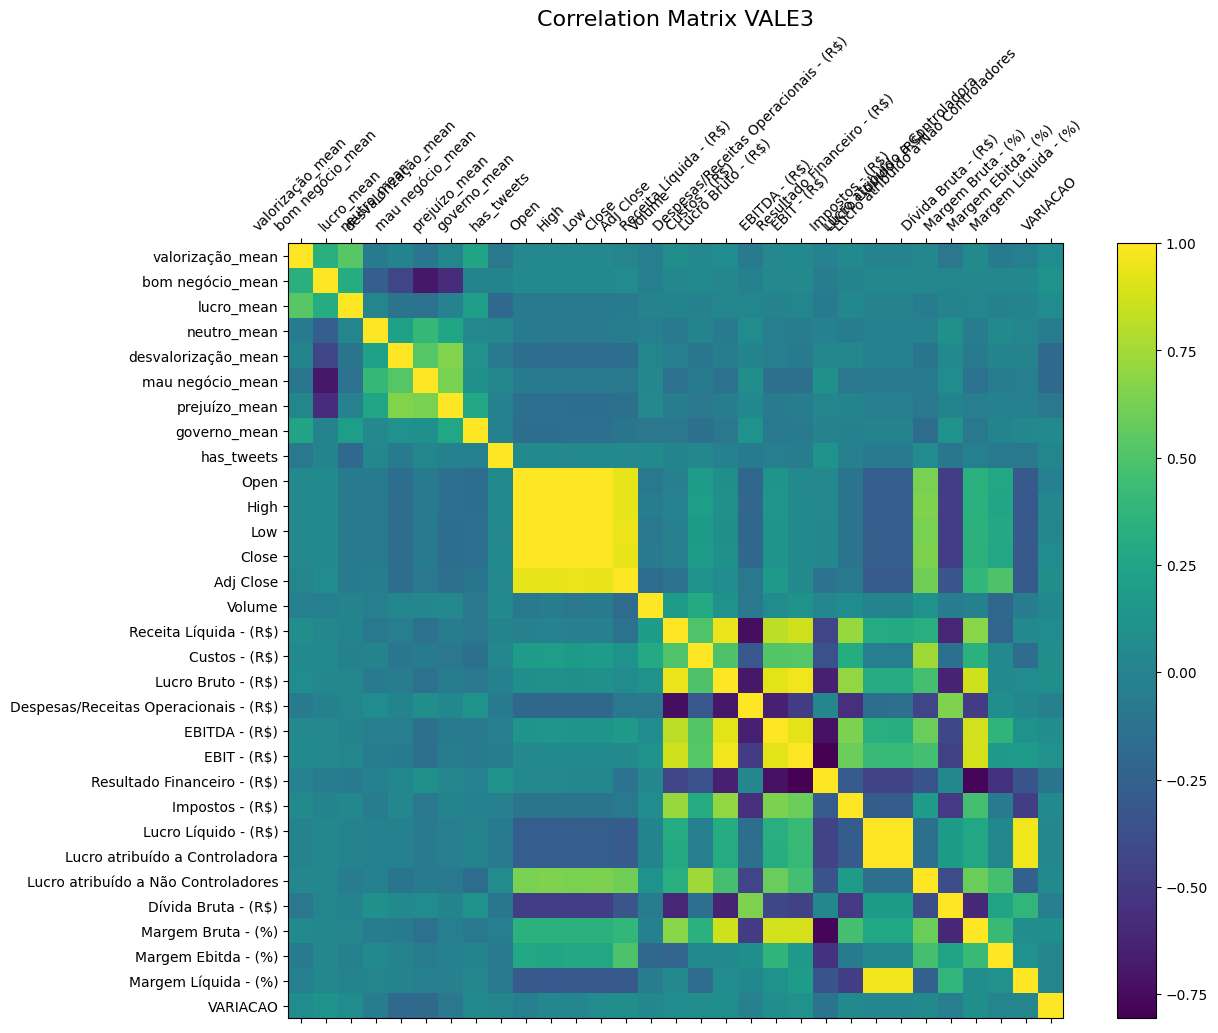

valorização_mean                         0.075020
bom negócio_mean                         0.124949
lucro_mean                               0.072942
neutro_mean                             -0.040116
desvalorização_mean                     -0.187989
mau negócio_mean                        -0.180303
prejuízo_mean                           -0.089256
governo_mean                             0.052995
has_tweets                               0.024889
Open                                    -0.022999
High                                     0.027093
Low                                      0.025387
Close                                    0.066649
Adj Close                                0.086622
Volume                                   0.036778
Receita Líquida - (R$)                   0.075103
Custos - (R$)                            0.087712
Lucro Bruto - (R$)                       0.093595
Despesas/Receitas Operacionais - (R$)   -0.016701
EBITDA - (R$)                            0.080823


In [44]:

for acao, df in acoes.items():
    variacao = (df["Close"].iloc[1:].to_numpy() - df["Close"].iloc[:-1].to_numpy()).tolist()
    variacao = [0] + variacao
    df["VARIACAO"] = variacao
    f = plt.figure(figsize=(14, 10))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=10)
    plt.title(f'Correlation Matrix {acao}', fontsize=16)
    plt.show()

    print(df.corr()["VARIACAO"])
